In [10]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display, Markdown, Latex
import scipy
import matplotlib.transforms as mtrans

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [11]:
def meta_analysis(effects, se, method="random", weights=None):
    # From Omer Weissbrod
    assert method in ["fixed", "random"]
    d = effects
    variances = se ** 2

    # compute random-effects variance tau2
    vwts = 1.0 / variances
    fixedsumm = vwts.dot(d) / vwts.sum()
    Q = np.sum(((d - fixedsumm) ** 2) / variances)
    df = len(d) - 1
    tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))

    # defing weights
    if weights is None:
        if method == "fixed":
            wt = 1.0 / variances
        else:
            wt = 1.0 / (variances + tau2)
    else:
        wt = weights

    # compute summtest
    summ = wt.dot(d) / wt.sum()
    if method == "fixed":
        varsum = np.sum(wt * wt * variances) / (np.sum(wt) ** 2)
    else:
        varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
    ###summtest = summ / np.sqrt(varsum)

    summary = summ
    se_summary = np.sqrt(varsum)

    return summary, se_summary

In [12]:
# gwas_gene_list = (
#     [f"top-{n}" for n in [100, 500, 1000, 2000]]
#     + [f"fwer5-{n}" for n in [1000, 2000]]
#     + [f"fdr1-{n}" for n in [1000, 2000]]
#     + [f"fdr5-{n}" for n in [1000, 2000]]
# )

gwas_gene_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fdr1-{n}" for n in [2000]]
    + [f"fwer5-{n}" for n in [2000]]
)

gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_gene_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

In [13]:
df_plot = pd.read_csv("power-analysis.csv")

# normalize by the maximum statistics by trait, rep_i
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].mean()
    df_plot_normalized.append(df_group)
df_plot_normalized = pd.concat(df_plot_normalized)

# then average across trait for each `method` and `rep_i`
df_plot = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()

In [14]:
df_plot["gwas_weight"] = df_plot["method"].apply(lambda x: x.split(".")[0])
df_plot["sc_weight"] = df_plot["method"].apply(lambda x: x.split(".")[1])

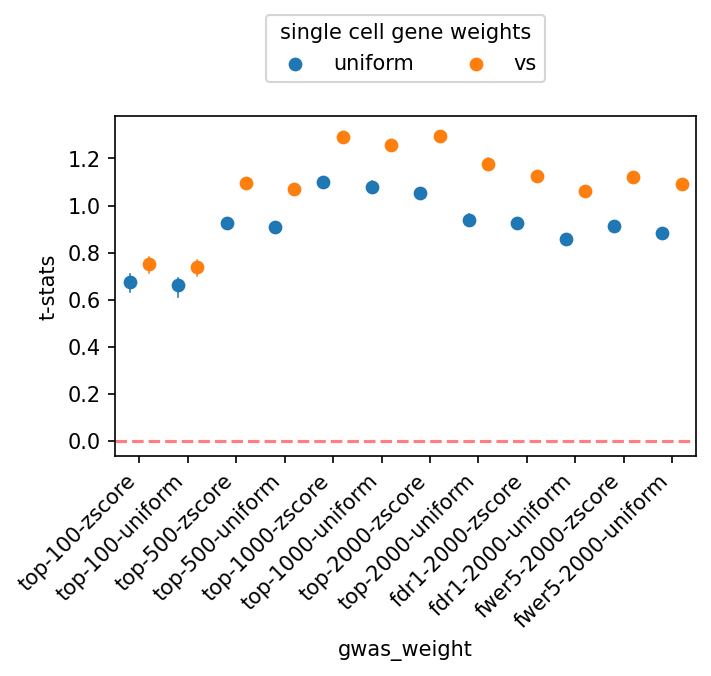

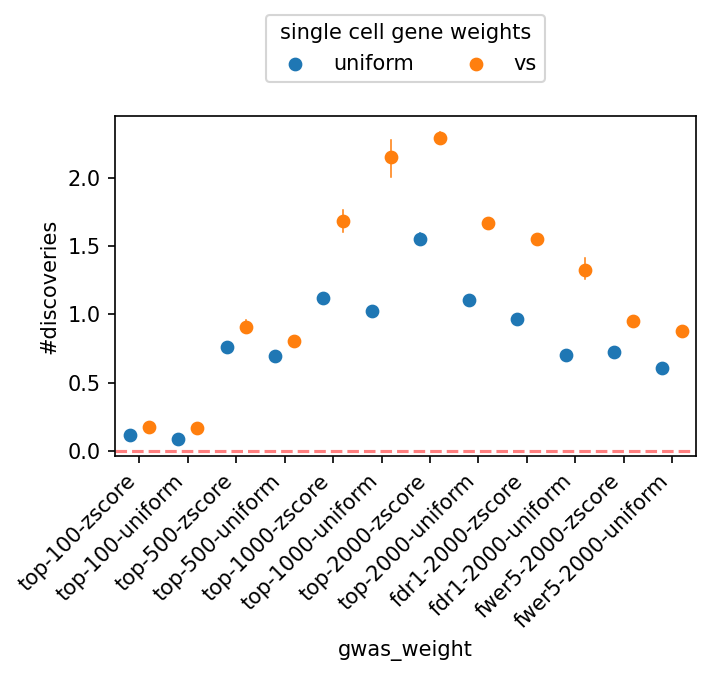

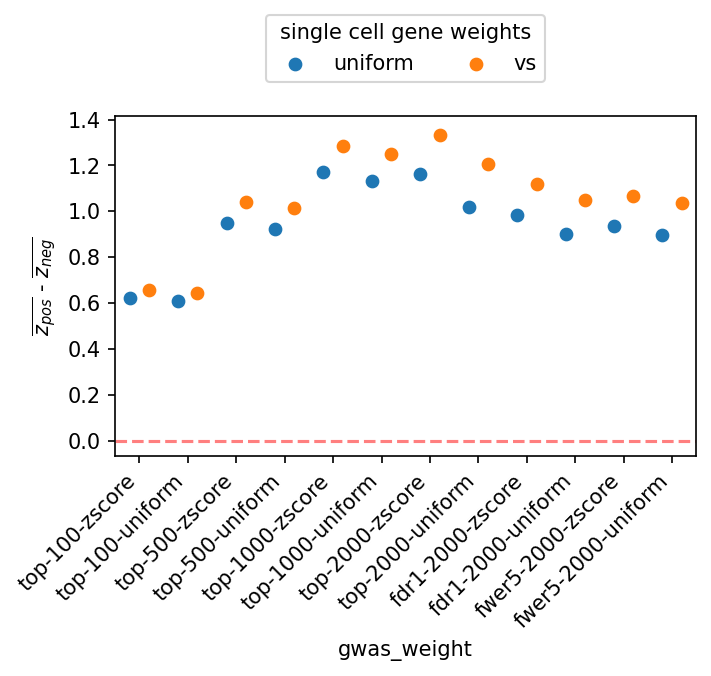

In [15]:
for y in ["tstats", "n_discovery", "meanshift"]:
    fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
    sns.pointplot(
        data=df_plot,
        x="gwas_weight",
        order=gwas_weight_list,
        y=y,
        hue="sc_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(
        loc="center",
        bbox_to_anchor=[0.5, 1.2],
        ncol=2,
        title="single cell gene weights",
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

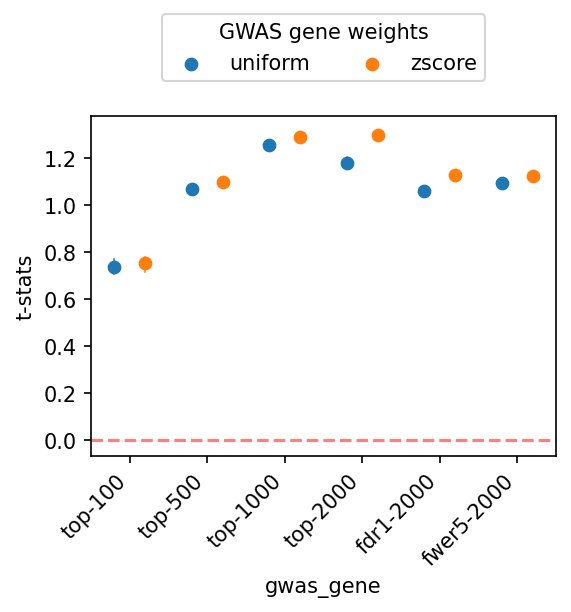

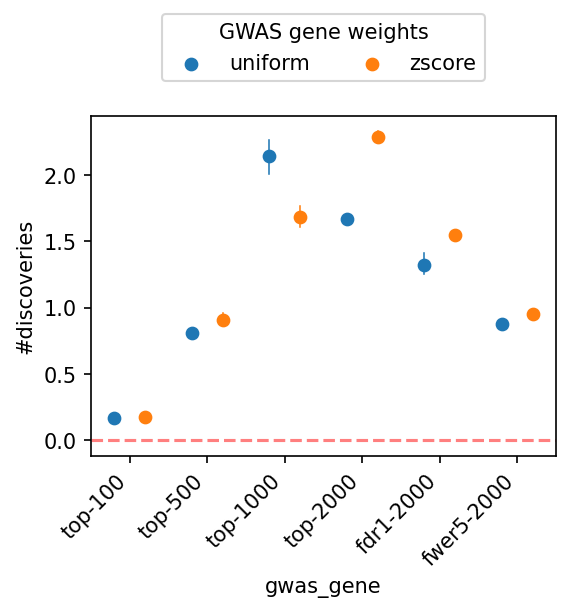

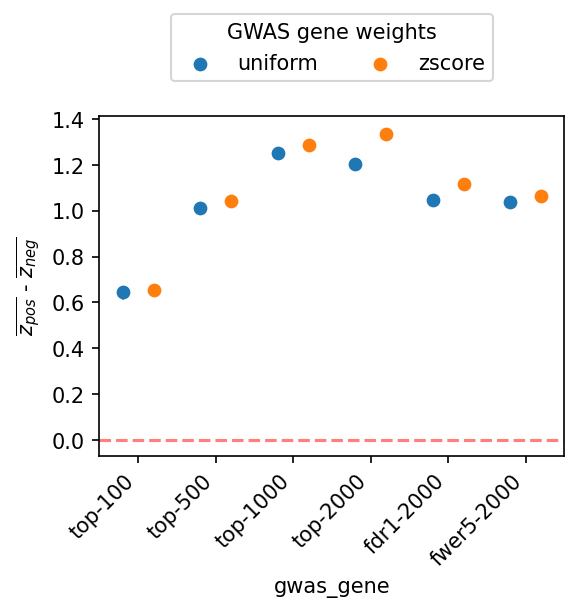

In [16]:
for y in ["tstats", "n_discovery", "meanshift"]:
    df_tmp = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])
    df_tmp["gwas_gene"] = df_tmp["gwas_weight"].apply(lambda x: x.rsplit("-", 1)[0])
    df_tmp["gwas_gene_weight"] = df_tmp["gwas_weight"].apply(
        lambda x: x.rsplit("-", 1)[1]
    )

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
    sns.pointplot(
        data=df_tmp,
        x="gwas_gene",
        y=y,
        order=gwas_gene_list,
        hue="gwas_gene_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(
        loc="center", bbox_to_anchor=[0.5, 1.2], ncol=2, title="GWAS gene weights"
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

# Numerical table for the results

In [17]:
df_plot = pd.read_csv("power-analysis.csv")

# normalize by the average statistics (across method) for each trait, rep_i
df_plot_normalized = []
for (trait, rep_i), df_group in df_plot.groupby(["trait", "rep_i"]):
    for col in ["n_discovery", "tstats", "meanshift"]:
        df_group[col] /= df_group[col].mean()
    df_plot_normalized.append(df_group)
df_plot = pd.concat(df_plot_normalized)

# # then meta-analyze across traits for each `method` and `rep_i`
# df_mean = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()
# df_sem = df_plot_normalized.groupby(["method", "rep_i"]).mean().reset_index()

# for df_tmp in [df_mean, df_sem]:
#     df_tmp["gwas_selection"] = df_tmp["method"].apply(
#         lambda x: x.split(".")[0].rsplit("-", 1)[0]
#     )
#     df_tmp["gwas_weight"] = df_tmp["method"].apply(
#         lambda x: x.split(".")[0].rsplit("-", 1)[1]
#     )
#     df_tmp["sc_weight"] = df_tmp["method"].apply(lambda x: x.split(".")[1])

# meta-analyze across traits for each method

In [18]:
# Calculate the mean and SE for each trait and method across 20 replicates
df_mean = df_plot.groupby(["trait", "method"]).mean().reset_index()
df_se = df_plot.groupby(["trait", "method"]).std().reset_index()

metric_list = ["n_discovery", "tstats", "meanshift"]
dict_df_res = dict()
for metric in metric_list:
    df_res = []
    # for each method, calculate the mean and se across 20 traits
    for method in df_plot.method.unique():
        method_mean, method_se = meta_analysis(
            df_mean[df_mean.method == method][metric],
            df_se[df_se.method == method][metric],
        )
        df_res.append([method, method_mean, method_se])
    df_res = pd.DataFrame(df_res, columns=["method", "mean", "se"])

    # format results
    df_res["gene_selection"] = df_res["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[0]
    )
    df_res["gwas_weight"] = df_res["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[1]
    )
    df_res["sc_weight"] = df_res["method"].apply(lambda x: x.split(".")[1])
    df_res["mean+se"] = (
        df_res["mean"].round(3).astype(str)
        + "("
        + df_res["se"].round(3).astype(str)
        + ")"
    )
    df_res = (
        df_res[["gene_selection", "gwas_weight", "sc_weight", "mean+se"]]
        .set_index(["gene_selection", "gwas_weight", "sc_weight"])
        .unstack(level=0)
        .reset_index()
    )
    df_res = df_res.set_index(["gwas_weight", "sc_weight"])["mean+se"][gwas_gene_list]
    dict_df_res[metric] = df_res

<ipython-input-11-a0893a5a92a4>:12: RuntimeWarning: invalid value encountered in double_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
<ipython-input-11-a0893a5a92a4>:28: RuntimeWarning: invalid value encountered in double_scalars
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)


In [19]:
dict_df_res["tstats"]

gene_selection              top-100       top-500      top-1000      top-2000  \
gwas_weight sc_weight                                                           
uniform     uniform     0.75(0.062)  0.933(0.039)  0.977(0.036)  0.892(0.061)   
            vs          0.84(0.065)  1.104(0.057)  1.142(0.032)  1.102(0.054)   
zscore      uniform    0.759(0.066)  0.955(0.035)   1.02(0.024)  1.004(0.041)   
            vs          0.85(0.066)  1.139(0.051)  1.211(0.031)  1.223(0.035)   

gene_selection            fdr1-2000    fwer5-2000  
gwas_weight sc_weight                              
uniform     uniform     0.858(0.04)  0.887(0.036)  
            vs          1.07(0.039)  1.098(0.038)  
zscore      uniform    0.926(0.033)  0.913(0.039)  
            vs         1.149(0.031)  1.136(0.039)

In [11]:
dict_df_res["tstats"].reset_index().to_excel("tstats.xlsx", index=False)

# pairwise comparison with the default settings

In [21]:
# df for the default method (top-1000-zscore.vs)
df_method_default = df_plot[df_plot.method == "top-1000-zscore.vs"].reset_index()

df_pairwise_res = []
for method in df_plot.method.unique():
    # for each other method
    df_method = df_plot[df_plot.method == method].reset_index()
    assert np.all(df_method_default.trait == df_method.trait)
    assert np.all(df_method_default.rep_i == df_method.rep_i)

    # compare the difference with the default method to this method
    # for each trait, calculate the mean and SE over 20 data sets
    df_diff = (
        pd.DataFrame(
            {
                "trait": df_method_default.trait,
                "rep_i": df_method_default.rep_i,
                "tstats_diff": df_method_default.tstats - df_method.tstats,
            }
        )
        .groupby("trait")
        .agg({"tstats_diff": ["mean", "std"]})
    )["tstats_diff"]

    # filter trait with zero sem
    df_diff = df_diff[df_diff["std"] > 0]
    # meta-analyze across 20 traits
    mean, se = meta_analysis(df_diff["mean"], df_diff["std"])

    df_pairwise_res.append([method, mean, se])

df_pairwise_res = pd.DataFrame(
    df_pairwise_res, columns=["method", "mean", "se"]
).set_index("method")

# calculate one-sided p-value based on z-score
df_pairwise_res["pval"] = scipy.stats.norm.sf(
    df_pairwise_res["mean"] / df_pairwise_res["se"]
)

<ipython-input-11-a0893a5a92a4>:9: RuntimeWarning: invalid value encountered in double_scalars
  fixedsumm = vwts.dot(d) / vwts.sum()
<ipython-input-11-a0893a5a92a4>:12: RuntimeWarning: invalid value encountered in double_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))
<ipython-input-11-a0893a5a92a4>:24: RuntimeWarning: invalid value encountered in double_scalars
  summ = wt.dot(d) / wt.sum()
<ipython-input-11-a0893a5a92a4>:28: RuntimeWarning: invalid value encountered in double_scalars
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)


Text(0.5, 1.0, 'Top 1,000 genes')

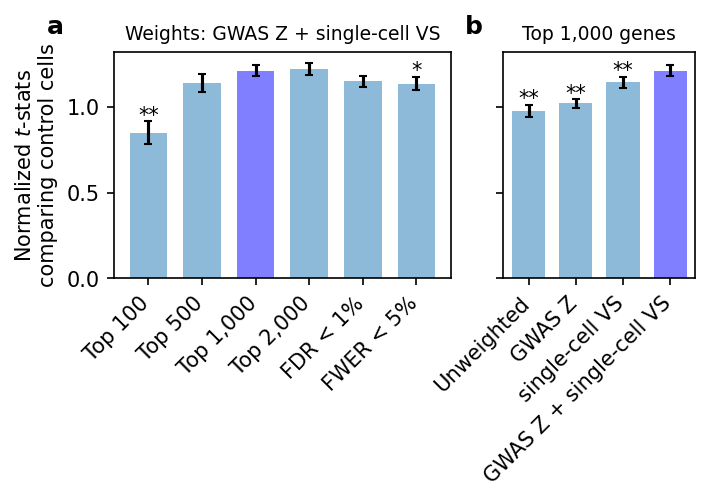

In [22]:
fig, axes = plt.subplots(
    figsize=(5, 2),
    dpi=150,
    ncols=2,
    sharey=True,
    gridspec_kw={"width_ratios": [7, 4]},
)

########################
# compare gene selection
########################
ax = axes[0]
mean_se = dict_df_res["tstats"].loc[("zscore", "vs")]
mean = [float(m.split("(")[0]) for m in mean_se]
se = [float(m.split("(")[1].split(")")[0]) for m in mean_se]
barplot = ax.bar(
    np.arange(len(mean)),
    mean,
    yerr=se,
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=2,
    width=0.7,
)

# highlight default setting
barplot[2].set_facecolor("blue")

# add asterisks for pairwise signficance
pval_list = df_pairwise_res.loc[
    [i + "-zscore.vs" for i in mean_se.index],
    "pval",
]

for i, (p, pval) in enumerate(zip(barplot.patches, pval_list)):
    if pval < 0.001:
        text = "**"
    elif pval < 0.05:
        text = "*"
    else:
        text = ""
    ax.text(p.get_x() + p.get_width() / 2.0, p.get_height() + se[i], text, ha="center")


label_dict = {
    "top-100": "Top 100",
    "top-500": "Top 500",
    "top-1000": "Top 1,000",
    "top-2000": "Top 2,000",
    "fwer5-2000": "FWER < 5%",
    "fdr1-2000": "FDR < 1%",
    "fdr5-2000": "FDR < 5%",
}
ax.set_ylabel(
    "Normalized $t$-stats\ncomparing control cells",
    fontsize=10,
)
ax.set_xticks(np.arange(len(mean)))
ax.set_xticklabels([label_dict[i] for i in mean_se.index], rotation=45, ha="right")
ax.set_title("Weights: GWAS Z + single-cell VS", fontsize=9)
# annotation
ax.text(
    -0.2,
    1.08,
    "a",
    transform=ax.transAxes,
    size=12,
    weight="bold",
)
# ax.tick_params(bottom=False, pad=-2)
trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)


######################
# compare gene weights
######################
ax = axes[1]
order = [
    ("uniform", "uniform"),
    ("zscore", "uniform"),
    ("uniform", "vs"),
    ("zscore", "vs"),
]

mean_se = dict_df_res["tstats"]["top-1000"].loc[order]
mean = [float(m.split("(")[0]) for m in mean_se]
se = [float(m.split("(")[1].split(")")[0]) for m in mean_se]


barplot = ax.bar(
    np.arange(len(mean)),
    mean,
    yerr=se,
    align="center",
    alpha=0.5,
    ecolor="black",
    capsize=2,
    width=0.7,
)
# highlight default setting
barplot[3].set_facecolor("blue")


# add asterisks for pairwise signficance
pval_list = df_pairwise_res.loc[
    ["top-1000-" + i[0] + "." + i[1] for i in mean_se.index],
    "pval",
]
for i, (p, pval) in enumerate(zip(barplot.patches, pval_list)):
    if pval < 0.001:
        text = "**"
    elif pval <= 0.05:
        text = "*"
    else:
        text = ""
    ax.text(p.get_x() + p.get_width() / 2.0, p.get_height() + se[i], text, ha="center")


ax.set_xticks(np.arange(len(mean)))
ax.set_xticklabels(
    ["Unweighted", "GWAS Z", "single-cell VS", "GWAS Z + single-cell VS"],
    rotation=45,
    fontsize=10,
    ha="right",
)
# annotation
ax.text(
    -0.2,
    1.08,
    "b",
    transform=ax.transAxes,
    size=12,
    weight="bold",
)

trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

# ax.set_xticklabels(mean_se.index, rotation=90)
ax.set_title("Top 1,000 genes", fontsize=9)

# plt.savefig("mainfig.pdf", bbox_inches="tight")
# plt.savefig("mainfig.png", bbox_inches="tight")

# plt.tight_layout()

In [15]:
# format results
df_pairwise_res = df_pairwise_res.reset_index()
df_pairwise_res["gene_selection"] = df_pairwise_res["method"].apply(
    lambda x: x.split(".")[0].rsplit("-", 1)[0]
)
df_pairwise_res["gwas_weight"] = df_pairwise_res["method"].apply(
    lambda x: x.split(".")[0].rsplit("-", 1)[1]
)
df_pairwise_res["sc_weight"] = df_pairwise_res["method"].apply(
    lambda x: x.split(".")[1]
)
df_pairwise_res["mean+se"] = (
    df_pairwise_res["mean"].round(3).astype(str)
    + "("
    + df_pairwise_res["se"].round(3).astype(str)
    + ")"
)
df_pairwise_res = (
    df_pairwise_res[["gene_selection", "gwas_weight", "sc_weight", "mean+se"]]
    .set_index(["gene_selection", "gwas_weight", "sc_weight"])
    .unstack(level=0)
    .reset_index()
)
df_pairwise_res = df_pairwise_res.set_index(["gwas_weight", "sc_weight"])["mean+se"][
    gwas_gene_list
]
df_pairwise_res.reset_index().to_excel("tstats_pairwise_diff.xlsx", index=False)

In [16]:
df_pairwise_res

gene_selection              top-100       top-500      top-1000  \
gwas_weight sc_weight                                             
uniform     uniform    0.436(0.077)  0.271(0.048)   0.222(0.04)   
            vs         0.343(0.068)  0.112(0.054)  0.055(0.014)   
zscore      uniform    0.428(0.079)  0.249(0.048)   0.18(0.036)   
            vs         0.335(0.069)   0.073(0.05)      nan(nan)   

gene_selection              top-2000    fwer5-2000     fdr1-2000  \
gwas_weight sc_weight                                              
uniform     uniform     0.315(0.069)  0.291(0.052)  0.316(0.061)   
            vs          0.103(0.057)  0.094(0.035)  0.115(0.049)   
zscore      uniform     0.203(0.053)  0.263(0.054)  0.251(0.056)   
            vs         -0.017(0.037)  0.054(0.034)  0.043(0.035)   

gene_selection             fdr5-2000  
gwas_weight sc_weight                 
uniform     uniform      0.242(0.07)  
            vs          0.051(0.055)  
zscore      uniform      0.181(0.06)  
            vs         -0.022(0.035)

# Legacy code below
----------

In [ ]:
assert False

In [ ]:
dict_df_res = {m: dict() for m in ["n_discovery", "tstats", "meanshift"]}

for trait in df_plot.trait.unique():
    df_plot_trait = df_plot[df_plot.trait == trait].copy()

    df_plot_trait["gene_selection"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[0]
    )
    df_plot_trait["gwas_weight"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[0].rsplit("-", 1)[1]
    )
    df_plot_trait["sc_weight"] = df_plot_trait["method"].apply(
        lambda x: x.split(".")[1]
    )

    for metric in ["tstats", "meanshift", "n_discovery"]:
        df_tmp = (
            df_plot_trait.groupby(["gene_selection", "gwas_weight", "sc_weight"])
            .apply(lambda x: x[metric].mean())
            .unstack(level=0)
        ).reset_index()
        df_tmp.columns.name = None
        df_tmp = df_tmp.set_index(["gwas_weight", "sc_weight"])[gwas_gene_list]
        dict_df_res[metric][trait] = df_tmp
#     display(Markdown(f"## {trait}"))
#     display(df_tmp.style.highlight_quantile(color="yellow", axis=None, q_left=0.85))

In [ ]:
for metric in ["tstats", "n_discovery"]:
    df_avg = None
    for trait in dict_df_res[metric]:
        df_tmp = dict_df_res[metric][trait]
        if df_avg is None:
            df_avg = df_tmp
        else:
            df_avg += df_tmp
    df_avg /= len(dict_df_res[metric])

    with pd.option_context("display.precision", 3):
        display(
            df_avg.style.bar(axis=None, vmin=0, vmax=1.0).set_properties(
                **{"color": "black !important", "border": "2px black solid !important"}
            )
        )